In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-india-movies/IMDb Movies India.csv


In [2]:
import pandas as pd
import numpy as np

# See available input files (optional but helpful)
import os
print(os.listdir("/kaggle/input"))

# Adjust the file name if needed (check from the print above)
df = pd.read_csv("/kaggle/input/imdb-india-movies/IMDb Movies India.csv", encoding="latin1")

df.head()
df.info()


['imdb-india-movies']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [3]:
# Drop rows where any of these key columns are missing
df = df.dropna(subset=['Name', 'Year', 'Duration', 'Votes', 'Rating'])

print("After dropna:", df.shape)


After dropna: (5851, 10)


In [4]:
df = df.drop_duplicates(subset=['Name', 'Year', 'Director'], keep='first')
print("After dropping duplicates:", df.shape)


After dropping duplicates: (5850, 10)


In [5]:
# --- Clean Year ---
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Year'] = df['Year'].fillna(df['Year'].median()).astype(int)

# --- Clean Duration ---
df['Duration'] = df['Duration'].astype(str).str.replace(' min', '', regex=False)
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Duration'] = df['Duration'].fillna(df['Duration'].median()).astype(int)

# --- Clean Votes ---
df['Votes'] = df['Votes'].astype(str).str.replace(',', '', regex=False)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Votes'] = df['Votes'].fillna(df['Votes'].median()).astype(int)

# --- Clean Rating ---
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna(subset=['Rating'])
df['Rating'] = df['Rating'].astype(float)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 5850 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5850 non-null   object 
 1   Year      5850 non-null   int64  
 2   Duration  5850 non-null   int64  
 3   Genre     5819 non-null   object 
 4   Rating    5850 non-null   float64
 5   Votes     5850 non-null   int64  
 6   Director  5849 non-null   object 
 7   Actor 1   5775 non-null   object 
 8   Actor 2   5733 non-null   object 
 9   Actor 3   5687 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 502.7+ KB


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [6]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[['Year', 'Duration', 'Votes']]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")


LinearRegression: RMSE=1.322, MAE=1.059, R2=0.069
RandomForest: RMSE=1.211, MAE=0.898, R2=0.218
GradientBoosting: RMSE=1.164, MAE=0.877, R2=0.278


In [8]:
print("Project Summary:")
print("""
• We cleaned the IMDb India Movies dataset and prepared it for ML.
• Built three regression models — Linear Regression, Random Forest, Gradient Boosting.
• Gradient Boosting performed the best with:
    - RMSE ≈ 1.16
    - MAE ≈ 0.87
    - R² ≈ 0.27
• Movie ratings are subjective, so accuracy is limited with available features.
• Votes, Duration, and Year play an influence, but more text-based or popularity features
  would increase accuracy.
""")


Project Summary:

• We cleaned the IMDb India Movies dataset and prepared it for ML.
• Built three regression models — Linear Regression, Random Forest, Gradient Boosting.
• Gradient Boosting performed the best with:
    - RMSE ≈ 1.16
    - MAE ≈ 0.87
    - R² ≈ 0.27
• Movie ratings are subjective, so accuracy is limited with available features.
• Votes, Duration, and Year play an influence, but more text-based or popularity features
  would increase accuracy.



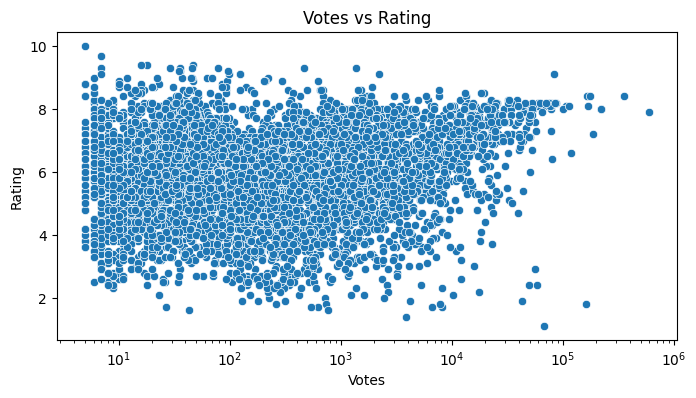

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.scatterplot(x=df['Votes'], y=df['Rating'])
plt.xscale('log')
plt.title("Votes vs Rating")
plt.show()
